== Версии библиотек ==
numpy: 2.0.2, scipy: 1.16.2, sklearn: 1.6.1
Using J_true from CR (bridge mode), N=50
Спектральный радиус J_true: 0.900  |  плотность(upper)≈0.249
Получено сэмплов: M=6000 (после burn-in и thinning)
Train: 4800   Test: 1200

== Инференс через псевдоликелихуд (LR по узлам) ==

== Оценка качества восстановления J ==
corr(Pearson, upper-tri): 0.929
ROC-AUC (edge detect):    0.703
PR-AUC  (edge detect):    0.560
MSE(J):                    0.000074
Sign accuracy (|J|>0):     0.492
||J_raw - J_raw^T||_F:     0.4559

== Conditional log-loss ==
Train: 0.6847   Test: 0.6874

== Визуализация ==


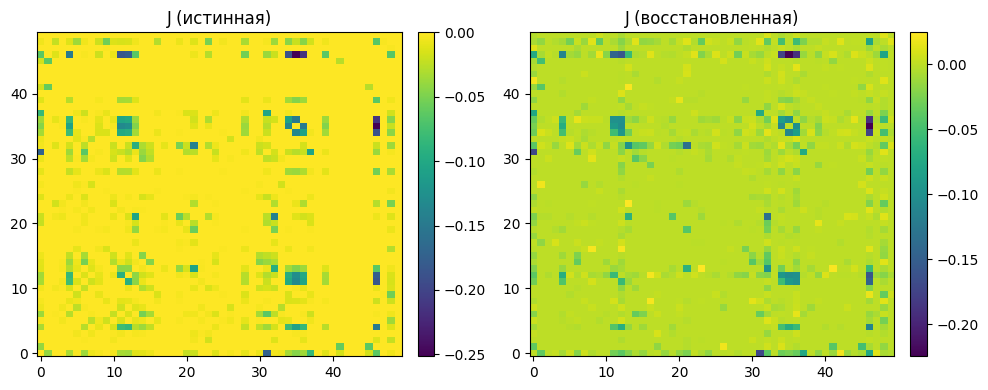

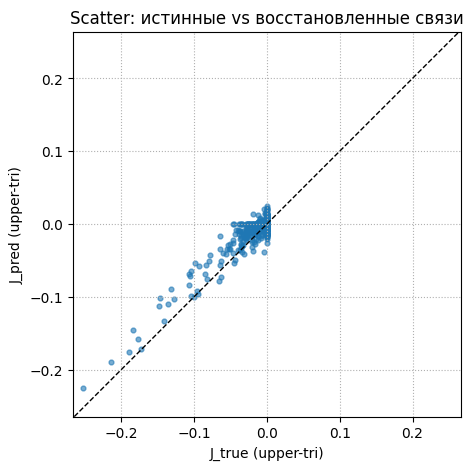

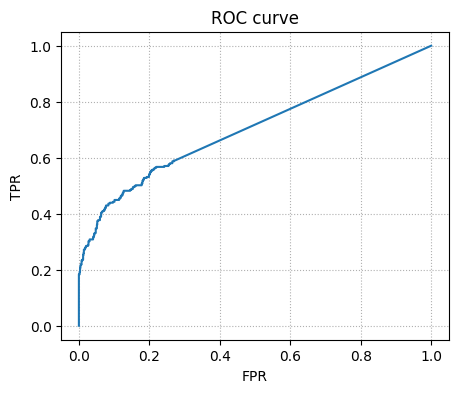

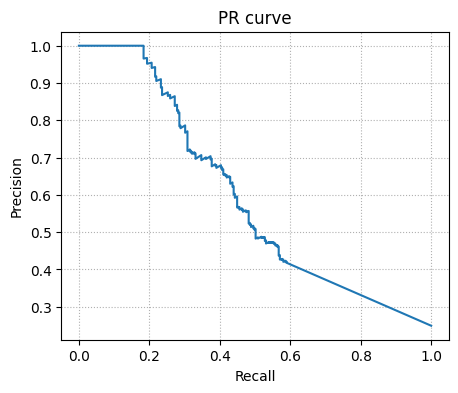

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Inverse Ising via Pseudolikelihood — расширенная версия:
- Bridge-mode: берём J_true из Consumer–Resource (если есть) ДО сэмплинга
- Hold-out валидация и conditional log-loss на тесте
- L1/L2 + LogisticRegressionCV (подбор C)
- Метрики: corr/ROC-AUC/PR-AUC/MSE, точность знака, норма асимметрии
- ROC/PR кривые
- (опц.) Аблация выключена по умолчанию
- Сохранение результатов в results/ (npz с meta)
"""

import os
import json
import numpy as np
from numpy.random import default_rng
from scipy.linalg import eigh
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, mean_squared_error,
    roc_curve, precision_recall_curve
)
import sklearn
import scipy

# ------------------------
# Утилиты: генерация J, поля h, спектральный рескейл
# ------------------------

def generate_sparse_symmetric_J(N, density=0.1, scale=0.8, rng=None):
    rng = default_rng() if rng is None else rng
    mask_upper = rng.random((N, N))
    mask_upper = np.triu((mask_upper < density).astype(float), k=1)
    vals_upper = rng.normal(loc=0.0, scale=scale, size=(N, N))
    vals_upper = np.triu(vals_upper, k=1)
    J = vals_upper * mask_upper
    J = J + J.T
    np.fill_diagonal(J, 0.0)
    return J

def spectral_rescale(J, target_radius=0.9):
    w = eigh(J, eigvals_only=True)
    r = np.max(np.abs(w))
    if r > 0:
        return (target_radius / r) * J
    return J.copy()

def generate_fields(N, scale_h=0.0, rng=None):
    rng = default_rng() if rng is None else rng
    return rng.normal(loc=0.0, scale=scale_h, size=N)

# ------------------------
# Гиббс-сэмплер
# ------------------------

def gibbs_sampler(J, h, beta=1.0, n_sweeps=5000, burn_in=1000, thin=5, rng=None, init=None):
    rng = default_rng() if rng is None else rng
    N = J.shape[0]
    if init is None:
        s = rng.choice(np.array([-1, 1], dtype=np.int8), size=N)
    else:
        s = np.array(init, dtype=np.int8)
        s[s == 0] = 1
        s = np.sign(s)
        s[s == 0] = 1

    samples = []
    for sweep in range(n_sweeps):
        for i in range(N):
            local_field = h[i] + np.dot(J[i, :], s) - J[i, i] * s[i]
            prob_up = 1.0 / (1.0 + np.exp(-2.0 * beta * local_field))
            s[i] = 1 if rng.random() < prob_up else -1
        if sweep >= burn_in and ((sweep - burn_in) % thin == 0):
            samples.append(s.copy())
    samples = np.array(samples, dtype=np.int8)
    return samples  # shape: (M, N)

# ------------------------
# Псевдоликелихуд (логистические регрессии по узлам)
# ------------------------

def fit_inverse_ising_pseudolikelihood(
    samples, penalty='l1', use_cv=True, C=1.0, cv_folds=5, Cs=10,
    max_iter=400, n_jobs=-1, intercept=True, random_state=0
):
    """
    Для каждого узла i учим логистическую регрессию:
    y = 1{s_i=+1}, X = s_{-i}. Коэффициенты /2 => J_ij, intercept/2 => h_i.
    Возвращает J_hat (симметризованную), h_hat, raw (до симметризации).
    """
    M, N = samples.shape
    J_hat_raw = np.zeros((N, N), dtype=float)
    h_hat = np.zeros(N, dtype=float)

    solver = 'saga' if penalty == 'l1' else 'lbfgs'

    if use_cv:
        base_solver = 'saga' if penalty == 'l1' else 'lbfgs'
        def lr_ctor():
            return LogisticRegressionCV(
                penalty=penalty, solver=base_solver,
                cv=cv_folds, Cs=Cs, scoring='neg_log_loss',
                max_iter=max_iter, n_jobs=n_jobs,
                fit_intercept=intercept, random_state=random_state, refit=True
            )
    else:
        def lr_ctor():
            return LogisticRegression(
                penalty=penalty, solver=solver, C=C,
                max_iter=max_iter,
                n_jobs=n_jobs if solver == 'saga' else None,
                fit_intercept=intercept, random_state=random_state
            )

    for i in range(N):
        y = (samples[:, i] == 1).astype(int)
        cols = [j for j in range(N) if j != i]
        X = samples[:, cols].astype(float)
        lr = lr_ctor()
        lr.fit(X, y)
        coefs = lr.coef_.ravel() / 2.0
        row = np.zeros(N, dtype=float)
        row[cols] = coefs
        J_hat_raw[i, :] = row
        h_hat[i] = (lr.intercept_[0] / 2.0) if intercept else 0.0

    J_hat = 0.5 * (J_hat_raw + J_hat_raw.T)
    np.fill_diagonal(J_hat, 0.0)
    return J_hat, h_hat, J_hat_raw

# ------------------------
# Метрики, кривые и служебные функции
# ------------------------

def upper_triangular(A):
    N = A.shape[0]
    iu = np.triu_indices(N, k=1)
    return A[iu]

def evaluate_J(J_true, J_pred, eps_zero=1e-12):
    jt = upper_triangular(J_true)
    jp = upper_triangular(J_pred)
    corr = np.corrcoef(jt, jp)[0, 1]
    y_true = (np.abs(jt) > eps_zero).astype(int)
    y_score = np.abs(jp)
    roc = pr = np.nan
    if len(np.unique(y_true)) == 2:
        roc = roc_auc_score(y_true, y_score)
        pr = average_precision_score(y_true, y_score)
    mse = mean_squared_error(J_true.ravel(), J_pred.ravel())
    return {"corr": corr, "roc_auc": roc, "pr_auc": pr, "mse": mse, "y_true": y_true, "y_score": y_score}

def sign_accuracy(J_true, J_pred, eps_zero=1e-12):
    mask = np.abs(J_true) > eps_zero
    if not np.any(mask):
        return np.nan
    return np.mean(np.sign(J_true[mask]) == np.sign(J_pred[mask]))

def asymmetry_fro_norm(J_raw):
    A = J_raw - J_raw.T
    return np.linalg.norm(A, ord='fro')

def conditional_logloss(samples, J, h, beta=1.0):
    """
    - (1 / (M*N)) * sum_{m,i} log P(s_i^{(m)} | s_{-i}^{(м)}),
    P = sigma(2 beta s_i (h_i + sum_j J_ij s_j))
    """
    M, N = samples.shape
    s = samples.astype(float)
    local = s @ J.T + h             # (M, N)
    z = 2.0 * beta * (s * local)    # elementwise
    log_sigma = -np.log1p(np.exp(-z))
    return float(-np.mean(log_sigma))

def plot_heatmaps(J_true, J_pred, savepath=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(J_true, origin='lower', aspect='auto')
    axes[0].set_title("J (истинная)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    im1 = axes[1].imshow(J_pred, origin='lower', aspect='auto')
    axes[1].set_title("J (восстановленная)")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def plot_scatter(J_true, J_pred, savepath=None, s=12, alpha=0.6):
    jt = upper_triangular(J_true)
    jp = upper_triangular(J_pred)
    lim = max(np.max(np.abs(jt)), np.max(np.abs(jp)))
    lim = max(lim * 1.05, 1e-3)
    plt.figure(figsize=(5, 5))
    plt.scatter(jt, jp, s=s, alpha=alpha)
    plt.plot([-lim, lim], [-lim, lim], 'k--', linewidth=1)
    plt.xlabel("J_true (upper-tri)")
    plt.ylabel("J_pred (upper-tri)")
    plt.title("Scatter: истинные vs восстановленные связи")
    plt.grid(True, ls=':')
    plt.axis('equal'); plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def plot_roc_pr_curves(y_true, y_score, save_prefix=None):
    if len(np.unique(y_true)) < 2:
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve")
    plt.grid(True, ls=':');
    if save_prefix: plt.savefig(f"{save_prefix}_roc.png", dpi=150)
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curve")
    plt.grid(True, ls=':');
    if save_prefix: plt.savefig(f"{save_prefix}_pr.png", dpi=150)
    plt.show()

# ------------------------
# Аблация (маленькая сетка) — по умолчанию выключена
# ------------------------

def ablation_study(
    N=40, betas=(0.7, 1.0), densities=(0.07, 0.12), Ms=(1500, 4000),
    J_scale=0.8, target_radius=0.9, seed=123, results_dir="results/ablation"
):
    os.makedirs(results_dir, exist_ok=True)
    rng = default_rng(seed)
    table = []
    for beta in betas:
        for density in densities:
            for M_target in Ms:
                J_true = spectral_rescale(
                    generate_sparse_symmetric_J(N, density=density, scale=J_scale, rng=rng),
                    target_radius=target_radius
                )
                h_true = generate_fields(N, scale_h=0.0, rng=rng)

                thin = 5
                burn_in = 1000
                n_sweeps = burn_in + M_target * thin

                samples = gibbs_sampler(J_true, h_true, beta=beta,
                                        n_sweeps=n_sweeps, burn_in=burn_in, thin=thin, rng=rng)

                M = samples.shape[0]
                idx = rng.permutation(M)
                tr_cut = int(0.8 * M)
                tr_idx, te_idx = idx[:tr_cut], idx[tr_cut:]
                tr, te = samples[tr_idx], samples[te_idx]

                J_hat, h_hat, J_raw = fit_inverse_ising_pseudolikelihood(
                    tr, penalty='l1', use_cv=True, cv_folds=5, Cs=8,
                    max_iter=400, n_jobs=-1, intercept=True, random_state=0
                )

                m = evaluate_J(J_true, J_hat)
                sign_acc = sign_accuracy(J_true, J_hat)
                asymm = asymmetry_fro_norm(J_raw)

                cll_tr = conditional_logloss(tr, J_hat, h_hat, beta=beta)
                cll_te = conditional_logloss(te, J_hat, h_hat, beta=beta)

                row = dict(beta=beta, density=density, M=M, corr=float(m["corr"]),
                           roc_auc=float(m["roc_auc"]) if not np.isnan(m["roc_auc"]) else None,
                           pr_auc=float(m["pr_auc"]) if not np.isnan(m["pr_auc"]) else None,
                           mse=float(m["mse"]), sign_acc=float(sign_acc), asymm=float(asymm),
                           cll_train=float(cll_tr), cll_test=float(cll_te))
                table.append(row)

                with open(os.path.join(results_dir, f"beta{beta}_dens{density}_M{M}.json"), "w") as f:
                    json.dump(row, f, indent=2)
    print("\n== Аблация (сводка) ==")
    hdr = ["beta","density","M","corr","roc_auc","pr_auc","mse","sign_acc","asymm","cll_train","cll_test"]
    print("\t".join(hdr))
    for r in table:
        print("\t".join(str(r[k]) for k in hdr))
    return table

# ------------------------
# Основной сценарий
# ------------------------

def main():
    os.makedirs("results", exist_ok=True)

    print("== Версии библиотек ==")
    print(f"numpy: {np.__version__}, scipy: {scipy.__version__}, sklearn: {sklearn.__version__}")

    rng = default_rng(42)

    # --- Параметры сэмплера ---
    beta = 1.0
    burn_in = 1500
    thin = 5
    total_kept = 6000
    n_sweeps = burn_in + total_kept * thin

    # --- Настройки логистической регрессии ---
    penalty = 'l1'
    use_cv = True
    C_reg = 0.5           # если use_cv=False
    cv_folds = 5
    Cs = 8
    max_iter = 400
    n_jobs = -1
    fit_intercept = True

    # === Bridge input из CR (ДО сэмплинга) ===
    CR_J_PATH = "results/J_target_from_CR.npz"
    bridge_mode = False
    target_radius = 0.9   # для случайного J; CR-матрица уже отрескейлена

    if os.path.exists(CR_J_PATH):
        pack = np.load(CR_J_PATH, allow_pickle=True)
        J_true = pack["J_target"].astype(float)
        N = J_true.shape[0]
        h_true = np.zeros(N)  # без внешних полей
        bridge_mode = True
        print(f"Using J_true from CR (bridge mode), N={N}")
    else:
        # --- fallback: случайный J_true ---
        N = 50
        density = 0.10
        J_scale = 0.8
        h_scale = 0.0
        J_true = generate_sparse_symmetric_J(N, density=density, scale=J_scale, rng=rng)
        J_true = spectral_rescale(J_true, target_radius=target_radius)
        h_true = generate_fields(N, scale_h=h_scale, rng=rng)
        print(f"Using random J_true, N={N}, density≈{density}")

    # Диагностика истинного J
    w = eigh(J_true, eigvals_only=True)
    rho = np.max(np.abs(w))
    dens_meta = np.count_nonzero(np.triu(np.abs(J_true) > 1e-12, 1)) / (N * (N - 1) / 2)
    print(f"Спектральный радиус J_true: {rho:.3f}  |  плотность(upper)≈{dens_meta:.3f}")

    # == Сэмплинг Гиббсом ==
    samples = gibbs_sampler(J_true, h_true, beta=beta,
                            n_sweeps=n_sweeps, burn_in=burn_in, thin=thin, rng=rng)
    M = samples.shape[0]
    print(f"Получено сэмплов: M={M} (после burn-in и thinning)")

    # --- Hold-out split ---
    idx = rng.permutation(M)
    tr_cut = int(0.8 * M)
    tr_idx, te_idx = idx[:tr_cut], idx[tr_cut:]
    samples_tr, samples_te = samples[tr_idx], samples[te_idx]
    print(f"Train: {samples_tr.shape[0]}   Test: {samples_te.shape[0]}")

    print("\n== Инференс через псевдоликелихуд (LR по узлам) ==")
    J_hat, h_hat, J_raw = fit_inverse_ising_pseudolikelihood(
        samples_tr, penalty=penalty, use_cv=use_cv, C=C_reg, cv_folds=cv_folds, Cs=Cs,
        max_iter=max_iter, n_jobs=n_jobs, intercept=fit_intercept, random_state=0
    )

    # --- Метрики восстановления J ---
    print("\n== Оценка качества восстановления J ==")
    metrics = evaluate_J(J_true, J_hat)
    print(f"corr(Pearson, upper-tri): {metrics['corr']:.3f}")
    print(f"ROC-AUC (edge detect):    {metrics['roc_auc']:.3f}" if not np.isnan(metrics['roc_auc']) else "ROC-AUC: n/a")
    print(f"PR-AUC  (edge detect):    {metrics['pr_auc']:.3f}" if not np.isnan(metrics['pr_auc']) else "PR-AUC: n/a")
    print(f"MSE(J):                    {metrics['mse']:.6f}")
    sign_acc = sign_accuracy(J_true, J_hat)
    print(f"Sign accuracy (|J|>0):     {sign_acc:.3f}")
    asymm = asymmetry_fro_norm(J_raw)
    print(f"||J_raw - J_raw^T||_F:     {asymm:.4f}")

    # --- Conditional log-loss на train/test ---
    cll_tr = conditional_logloss(samples_tr, J_hat, h_hat, beta=beta)
    cll_te = conditional_logloss(samples_te, J_hat, h_hat, beta=beta)
    print("\n== Conditional log-loss ==")
    print(f"Train: {cll_tr:.4f}   Test: {cll_te:.4f}")

    # --- Визуализации ---
    print("\n== Визуализация ==")
    plot_heatmaps(J_true, J_hat, savepath="results/heatmaps.png")
    plot_scatter(J_true, J_hat, savepath="results/scatter.png")
    plot_roc_pr_curves(metrics["y_true"], metrics["y_score"], save_prefix="results/curves")

    # --- Сохранение артефактов ---
    np.savez_compressed(
        "results/results_core.npz",
        J_true=J_true, J_hat=J_hat, J_raw=J_raw, h_true=h_true, h_hat=h_hat,
        metrics_core=np.array([
            metrics['corr'],
            metrics['roc_auc'] if not np.isnan(metrics['roc_auc']) else -1.0,
            metrics['pr_auc'] if not np.isnan(metrics['pr_auc']) else -1.0,
            metrics['mse'], sign_acc, asymm, cll_tr, cll_te
        ], dtype=float),
        meta=np.array([N, dens_meta, beta, target_radius, M, float(bridge_mode)], dtype=float)
    )
    with open("results/metrics_readable.json","w") as f:
        out = dict(
            corr=float(metrics['corr']),
            roc_auc=None if np.isnan(metrics['roc_auc']) else float(metrics['roc_auc']),
            pr_auc=None if np.isnan(metrics['pr_auc']) else float(metrics['pr_auc']),
            mse=float(metrics['mse']),
            sign_accuracy=float(sign_acc),
            asymmetry_fro_norm=float(asymm),
            conditional_logloss_train=float(cll_tr),
            conditional_logloss_test=float(cll_te),
            N=int(N), density=float(dens_meta), beta=float(beta),
            target_radius=float(target_radius), M=int(M),
            bridge_mode=bool(bridge_mode),
            libs=dict(numpy=np.__version__, scipy=scipy.__version__, sklearn=sklearn.__version__)
        )
        json.dump(out, f, indent=2, ensure_ascii=False)

    # --- Аблация (по умолчанию выключена, чтобы не мешала бриджу) ---
    RUN_ABLATION = False
    if RUN_ABLATION:
        ablation_study(
            N=40, betas=(0.7, 1.0), densities=(0.07, 0.12), Ms=(1500, 3000),
            J_scale=0.8, target_radius=0.9, seed=777, results_dir="results/ablation"
        )

if __name__ == "__main__":
    main()

[Init] Найден Inverse Ising NPZ: n_species=50 (из J_hat)
== БАЗОВОЕ ВОССТАНОВЛЕНИЕ (Lasso) | n_species=50, n_res=10 ==
RMSE(C): 0.3226   MAE(C): 0.1101   ROC-AUC: 0.904   PR-AUC: 0.725
MAE(m): 0.0220   RMSE(m): 0.0562
Лучший F1=0.773 при пороге |C|>0.2511
[Sanity] corr(A_true, -J_true_from_ising) = 1.000

== NNLS-рефайн (fixed m_hat от Lasso) ==
RMSE(C): 0.3270   MAE(C): 0.1127   ROC-AUC: 0.901   PR-AUC: 0.715
[Sanity] corr(A_hat_lasso, A_true) = 0.532
[Sanity] corr(A_hat_nnls,  A_true) = 0.530

== УСТОЙЧИВОСТЬ ==
Feasibility: истина 0.16 | оценка 0.12
Stationarity residuals (истина): dR 4.32e-06, dn 3.15e-06
Stationarity residuals (оценка): dR 1.74e-05, dn 9.80e-06
max Re(λ) в истин. стац.: истина -0.0529 | оценка -0.0055
max Re(λ) в стац. по оценке: -0.0047


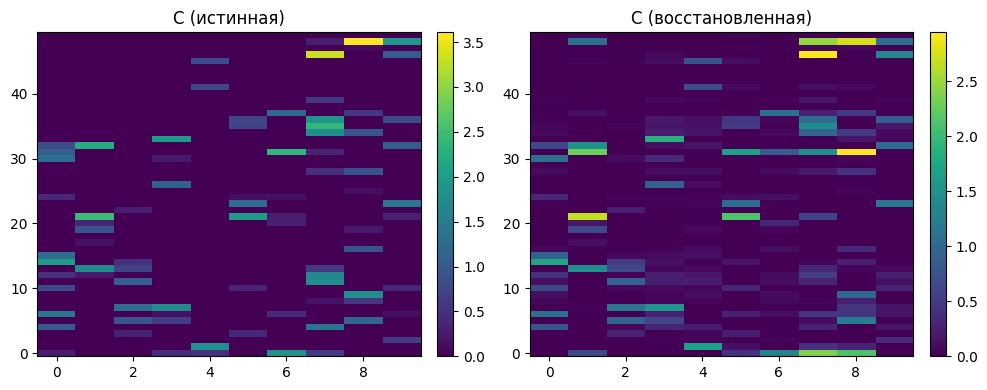

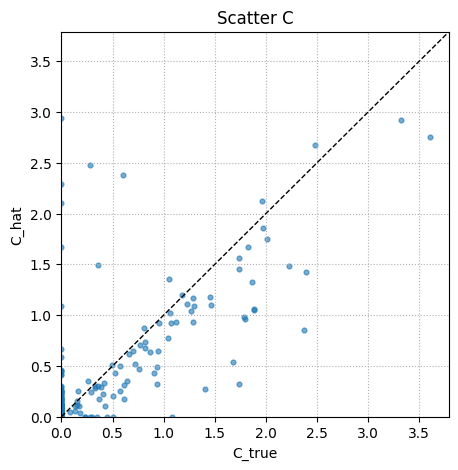

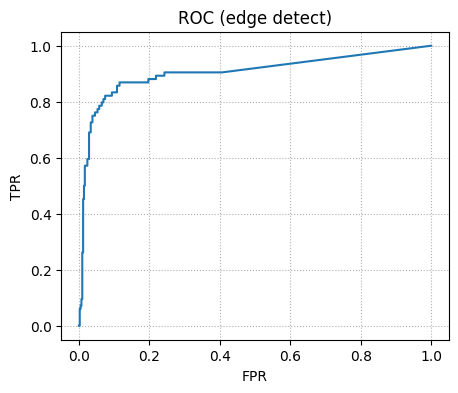

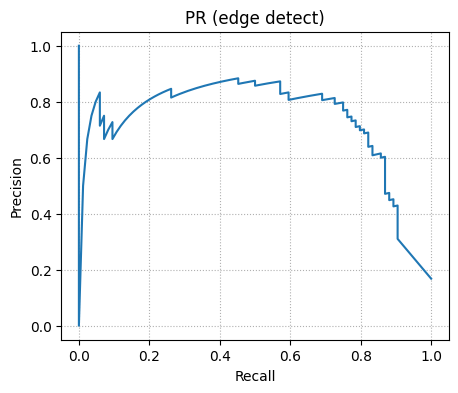

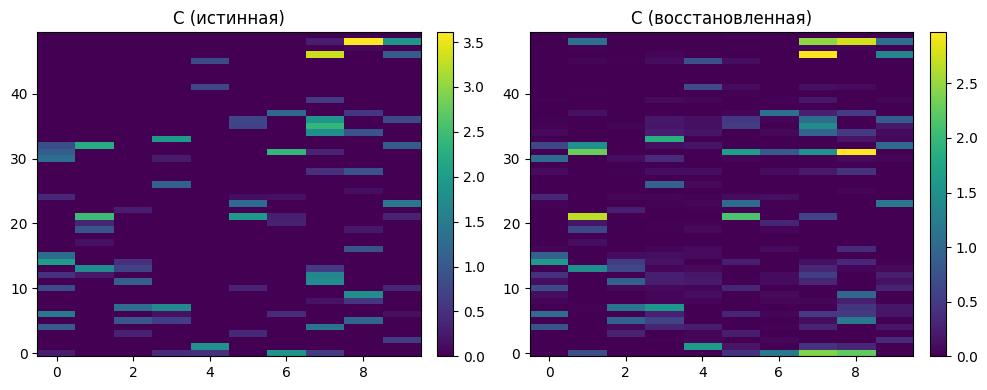

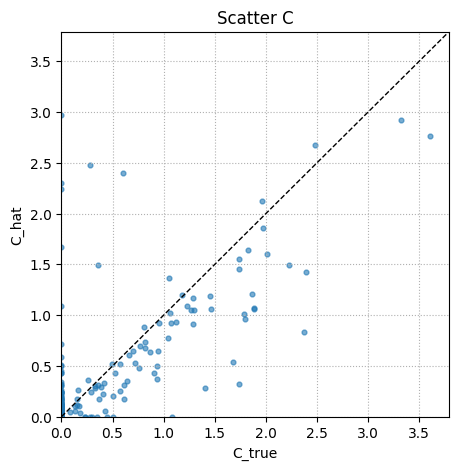

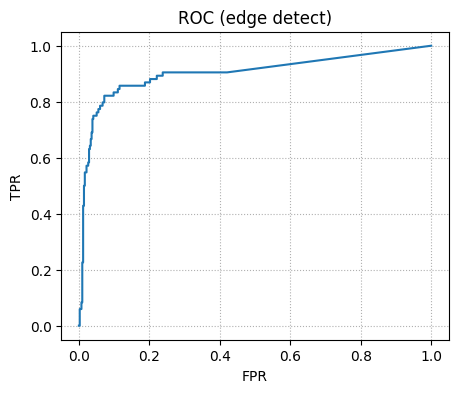

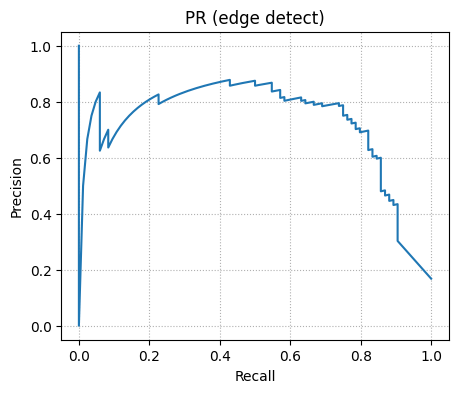


== Робастность к шуму (σ_R=σ_n=0.03) ==
RMSE(C): 0.6242   PR-AUC: 0.261   MAE(m): 0.7096


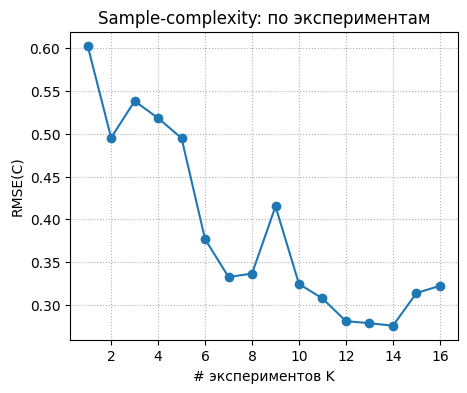

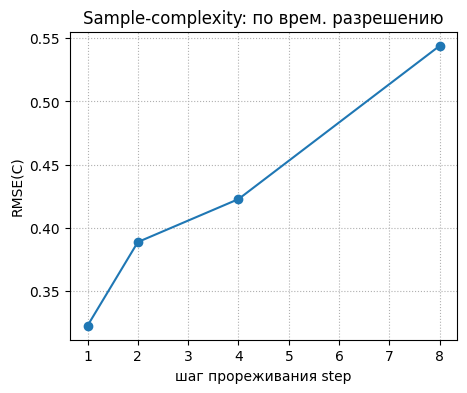

Saved bridge target -> results/J_target_from_CR.npz, shape: (50, 50)
[Sanity] corr(A_true(final), -J_true_from_ising) = 1.000
[Bridge] using J_true; corr(A_eff, -J_true)=0.530, ROC-AUC=0.888, PR-AUC=0.754, kappa*=-0.012


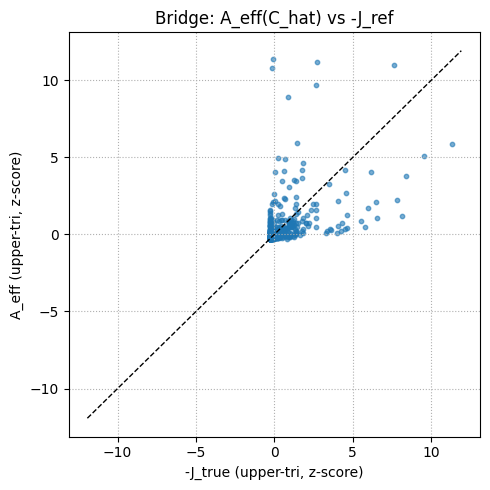

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Consumer–Resource (MacArthur): учим предпочтения и проверяем устойчивость
+ робастность к шуму, NNLS-рефайн, sample-complexity, F1-порог,
+ контроль стационара (residuals) и "мост" к Inverse Ising (A_eff vs J_*).

Автосинхронизация размеров:
- Читает results/results_core.npz из части A и берёт n_species = J_hat.shape[0] (если есть).
- Если файл не найден — использует дефолт N_SPECIES_DEFAULT.

Зависимости: numpy, scipy, scikit-learn, matplotlib
Запуск: python consumer_resource_plus.py
"""

import os
import numpy as np
from numpy.random import default_rng
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals
from scipy.optimize import nnls
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    mean_squared_error
)

# -------------------------
# Конфиг путей и автоопределение размера из Inverse Ising
# -------------------------
ISING_NPZ_PATH = "results/results_core.npz"
N_SPECIES_DEFAULT = 30   # используется, если NPZ не найден

def detect_n_species_from_ising(path=ISING_NPZ_PATH, default_n=N_SPECIES_DEFAULT):
    p = Path(path)
    if not p.exists():
        print(f"[Init] {path} не найден — использую n_species={default_n}")
        return default_n
    data = np.load(str(p), allow_pickle=True)
    if "J_hat" not in data:
        print(f"[Init] В {path} нет ключа 'J_hat' — использую n_species={default_n}")
        return default_n
    n = int(data["J_hat"].shape[0])
    print(f"[Init] Найден Inverse Ising NPZ: n_species={n} (из J_hat)")
    return n

# =========================
# Генерация параметров
# =========================

def generate_params(n_species=30, n_res=10, density=0.15,
                    c_scale=1.0, s_scale=2.0, d_scale=1.0, m_scale=0.6, seed=42):
    rng = default_rng(seed)
    mask = rng.random((n_species, n_res)) < density
    C = np.zeros((n_species, n_res))
    C[mask] = rng.gamma(shape=2.0, scale=c_scale/2.0, size=mask.sum())
    s = rng.gamma(shape=2.0, scale=s_scale/2.0, size=n_res) + 0.2
    d = rng.gamma(shape=2.0, scale=d_scale/2.0, size=n_res) + 0.2
    m = rng.gamma(shape=2.0, scale=m_scale/2.0, size=n_species) + 0.05
    return C, s, d, m

# =========================
# Динамика CR
# =========================

def cr_rhs(t, z, C, s, d, m):
    n_res = s.shape[0]; n_species = m.shape[0]
    R = z[:n_res]; n = z[n_res:]
    cons = (C.T @ n)                 # (n_res,)
    dR = s - d*R - R*cons
    growth = (C @ R) - m             # (n_species,)
    dn = n * growth
    return np.concatenate([dR, dn])

def simulate_experiment(C, s, d, m, t_span=(0,60.0), t_eval=None, R0=None, n0=None, seed=0):
    rng = default_rng(seed)
    n_res = s.shape[0]; n_species = m.shape[0]
    if R0 is None: R0 = rng.uniform(0.5, 2.0, size=n_res)
    if n0 is None: n0 = rng.uniform(0.1, 0.5, size=n_species)
    if t_eval is None: t_eval = np.linspace(t_span[0], t_span[1], 601)
    z0 = np.concatenate([R0, n0])
    sol = solve_ivp(cr_rhs, t_span, z0, t_eval=t_eval, args=(C, s, d, m), rtol=1e-6, atol=1e-9)
    R = sol.y[:n_res, :].T
    n = sol.y[n_res:, :].T
    return sol.t, R, n

def integrate_to_steady(C, s, d, m, seed=0, t_end=300.0, tol=1e-8, max_loops=3):
    """Интегрируем подольше, пока невязка стационара не станет < tol или не исчерпаем max_loops."""
    rng = default_rng(seed)
    R0 = rng.uniform(0.5, 2.0, size=s.shape[0])
    n0 = rng.uniform(0.1, 0.5, size=m.shape[0])
    t_eval = np.linspace(0, t_end, int(t_end*10)+1)
    for _ in range(max_loops):
        t, R, n = simulate_experiment(C, s, d, m, t_span=(0, t_end), t_eval=t_eval, R0=R0, n0=n0, seed=seed)
        R_star, n_star = R[-1], n[-1]
        res_R, res_n = stationarity_residuals(R_star, n_star, C, s, d, m)
        if max(res_R, res_n) < tol:
            break
        R0, n0 = R_star, n_star
        t_end *= 1.5
        t_eval = np.linspace(0, t_end, int(t_end*10)+1)
    return R_star, n_star

# =========================
# Стационарные невязки (residuals)
# =========================

def stationarity_residuals(R, n, C, s, d, m):
    cons = C.T @ n
    dR = s - d*R - R*cons
    growth = (C @ R) - m
    dn = n * growth
    res_R = float(np.max(np.abs(dR)))
    res_n = float(np.max(np.abs(dn)))
    return res_R, res_n

# =========================
# Подготовка данных для регрессии
# =========================

def time_derivative_central(x, t):
    dx = np.empty_like(x)
    dx[1:-1] = (x[2:] - x[:-2]) / (t[2:] - t[:-2])[:, None]
    dx[0]  = (x[1] - x[0]) / (t[1] - t[0])
    dx[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
    return dx

def smooth_time_series(R, n, window=11, poly=2):
    """Лёгкое сглаживание по времени для устойчивой производной."""
    R_sm = savgol_filter(R, window_length=window, polyorder=poly, axis=0, mode='interp')
    n_sm = savgol_filter(n, window_length=window, polyorder=poly, axis=0, mode='interp')
    R_sm = np.clip(R_sm, 0.0, None)
    n_sm = np.clip(n_sm, 0.0, None)
    return R_sm, n_sm

def build_regression_dataset(t_list, R_list, n_list, n_min=1e-4, step=1):
    """Возвращает X_i, y_i для каждого вида: y_i = dn_i/dt / n_i, X = R."""
    n_species = n_list[0].shape[1]; n_res = R_list[0].shape[1]
    per_species_X = [[] for _ in range(n_species)]
    per_species_y = [[] for _ in range(n_species)]
    for t, R, n in zip(t_list, R_list, n_list):
        t = t[::step]; R = R[::step]; n = n[::step]
        dn = time_derivative_central(n, t)
        y = dn / np.clip(n, n_min, None)
        for i in range(n_species):
            mask = n[:, i] > n_min
            per_species_X[i].append(R[mask])
            per_species_y[i].append(y[mask, i])
    X_per = [np.vstack(xs) if len(xs)>0 else np.zeros((0, n_res)) for xs in per_species_X]
    y_per = [np.concatenate(ys) if len(ys)>0 else np.zeros((0,)) for ys in per_species_y]
    return X_per, y_per

# =========================
# Обучение C,m
# =========================

def fit_lasso_positive(X_per_species, y_per_species, cv=5, random_state=0, max_iter=20000):
    """LassoCV (positive=True, intercept свободен). Возвращает (C_hat, m_hat)."""
    n_species = len(X_per_species)
    n_res = X_per_species[0].shape[1]
    C_hat = np.zeros((n_species, n_res)); m_hat = np.zeros(n_species)
    for i in range(n_species):
        X = X_per_species[i]; y = y_per_species[i]
        if X.shape[0] == 0: continue
        model = LassoCV(cv=cv, fit_intercept=True, positive=True,
                        random_state=random_state, n_jobs=-1, max_iter=max_iter)
        model.fit(X, y)
        C_hat[i] = model.coef_
        m_hat[i] = -model.intercept_
    return C_hat, m_hat

def nnls_refine_given_m(X_per_species, y_per_species, m_hat, nonneg_clip=True):
    """NNLS-рефайн: X_i c_i ≈ y_i + m_hat[i],  c_i >= 0."""
    n_species = len(X_per_species); n_res = X_per_species[0].shape[1]
    C_nn = np.zeros((n_species, n_res))
    for i in range(n_species):
        X = X_per_species[i]; y = y_per_species[i]
        if X.shape[0] == 0: continue
        target = y + m_hat[i]
        c_i, _ = nnls(X, target)
        if nonneg_clip: c_i = np.clip(c_i, 0, None)
        C_nn[i] = c_i
    return C_nn

# =========================
# Метрики и пороги
# =========================

def evaluate_C(C_true, C_hat, eps=1e-12):
    rmse = np.sqrt(mean_squared_error(C_true.ravel(), C_hat.ravel()))
    mae = np.mean(np.abs(C_true - C_hat))
    y_true = (C_true > eps).astype(int).ravel()
    y_score = C_hat.ravel()
    roc = pr = np.nan
    if len(np.unique(y_true)) == 2:
        roc = roc_auc_score(y_true, y_score)
        pr  = average_precision_score(y_true, y_score)
    return dict(rmse=rmse, mae=mae, roc_auc=roc, pr_auc=pr, y_true=y_true, y_score=y_score)

def evaluate_m(m_true, m_hat):
    mae = float(np.mean(np.abs(m_true - m_hat)))
    rmse = float(np.sqrt(np.mean((m_true - m_hat)**2)))
    return dict(mae=mae, rmse=rmse)

def best_f1_threshold(y_true, y_score):
    if len(np.unique(y_true)) < 2: return None, None
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    k = np.nanargmax(f1)
    thr_val = thr[k-1] if k>0 and (k-1) < len(thr) else np.median(y_score)
    return float(f1[k]), float(thr_val)

# =========================
# Устойчивость
# =========================

def jacobian_at_state(R, n, C, s, d, m):
    n_res = len(R); n_species = len(n)
    J_RR = np.zeros((n_res, n_res))
    J_Rn = np.zeros((n_res, n_species))
    J_nR = np.zeros((n_species, n_res))
    J_nn = np.zeros((n_species, n_species))
    cons = C.T @ n
    growth = (C @ R) - m
    for a in range(n_res):
        J_RR[a, a] = -(d[a] + cons[a])
        for i in range(n_species):
            J_Rn[a, i] = -C[i, a] * R[a]
    for i in range(n_species):
        for a in range(n_res):
            J_nR[i, a] = n[i] * C[i, a]
        J_nn[i, i] = growth[i]  # для выживших в стац. ~0
    return np.vstack([np.hstack([J_RR, J_Rn]), np.hstack([J_nR, J_nn])])

def feasibility(n_star, tol=1e-6):
    return float(np.mean(n_star > tol))

# =========================
# Визуализация
# =========================

def plot_heatmaps(C_true, C_hat, savepath=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(C_true, origin='lower', aspect='auto')
    axes[0].set_title("C (истинная)"); plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    im1 = axes[1].imshow(C_hat, origin='lower', aspect='auto')
    axes[1].set_title("C (восстановленная)"); plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def plot_scatter_C(C_true, C_hat, savepath=None, s=12, alpha=0.6):
    x = C_true.ravel(); y = C_hat.ravel()
    lim = max(np.max(x), np.max(y)); lim = max(lim*1.05, 1e-3)
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=s, alpha=alpha)
    plt.plot([0, lim], [0, lim], 'k--', lw=1)
    plt.xlabel("C_true"); plt.ylabel("C_hat"); plt.title("Scatter C")
    plt.grid(True, ls=':'); plt.xlim(0, lim); plt.ylim(0, lim)
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()

def plot_roc_pr(y_true, y_score, save_prefix=None):
    if len(np.unique(y_true)) < 2: return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    plt.figure(figsize=(5,4)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (edge detect)")
    plt.grid(True, ls=':');
    if save_prefix: plt.savefig(f"{save_prefix}_roc.png", dpi=150)
    plt.show()
    plt.figure(figsize=(5,4)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (edge detect)")
    plt.grid(True, ls=':');
    if save_prefix: plt.savefig(f"{save_prefix}_pr.png", dpi=150)
    plt.show()

def plot_sample_complexity(curve_exp, curve_step, save_prefix="cr_results/sample_complexity"):
    plt.figure(figsize=(5,4))
    xs = [k for k,_ in curve_exp]; ys = [m['rmse'] for _,m in curve_exp]
    plt.plot(xs, ys, marker='o'); plt.xlabel("# экспериментов K"); plt.ylabel("RMSE(C)")
    plt.title("Sample-complexity: по экспериментам"); plt.grid(True, ls=':')
    plt.savefig(f"{save_prefix}_experiments.png", dpi=150); plt.show()

    plt.figure(figsize=(5,4))
    xs = [st for st,_ in curve_step]; ys = [m['rmse'] for _,m in curve_step]
    plt.plot(xs, ys, marker='o'); plt.xlabel("шаг прореживания step"); plt.ylabel("RMSE(C)")
    plt.title("Sample-complexity: по врем. разрешению"); plt.grid(True, ls=':')
    plt.savefig(f"{save_prefix}_time_step.png", dpi=150); plt.show()

# =========================
# Шум/робастность
# =========================

def add_measurement_noise(R_list, n_list, sigma_R=0.02, sigma_n=0.02, seed=0):
    rng = default_rng(seed)
    Rn = []; nn = []
    for R, n in zip(R_list, n_list):
        R_noisy = np.clip(R + rng.normal(0, sigma_R, size=R.shape), 0.0, None)
        n_noisy = np.clip(n + rng.normal(0, sigma_n, size=n.shape), 0.0, None)
        Rn.append(R_noisy); nn.append(n_noisy)
    return Rn, nn

# =========================
# BRIDGE: A_eff(C) vs J_ref (из Inverse Ising NPZ)
# =========================

def bridge_compare_Aeff_vs_J(C_hat, d, path_to_ising_npz=ISING_NPZ_PATH, out_prefix="cr_results/bridge"):
    p = Path(path_to_ising_npz)
    if not p.exists():
        print("[Bridge] Файл Inverse Ising не найден, пропускаю сравнение.")
        return None
    data = np.load(str(p), allow_pickle=True)

    # берём J_ref из NPZ: сначала J_true (если есть), иначе J_hat
    if "J_true" in data.files:
        J_ref, src = data["J_true"].astype(float), "J_true"
    elif "J_hat" in data.files:
        J_ref, src = data["J_hat"].astype(float), "J_hat"
    else:
        print("[Bridge] В NPZ нет ни J_true, ни J_hat — пропускаю.")
        return None

    n_species = C_hat.shape[0]
    if J_ref.shape[0] != n_species:
        print(f"[Bridge] Размеры не совпадают (J_ref {J_ref.shape[0]} vs species {n_species}), пропускаю.")
        return None

    # A_eff из оценённого C
    A_eff = C_hat @ np.diag(1.0/d) @ C_hat.T
    np.fill_diagonal(A_eff, 0.0)

    iu = np.triu_indices(n_species, 1)
    a_raw = A_eff[iu].astype(float)
    j_raw = (-J_ref[iu]).astype(float)       # конкуренция ⇒ J ≈ -κ·A_eff

    # z-score нормировка (убираем масштаб/смещение)
    a = (a_raw - a_raw.mean()) / (a_raw.std() + 1e-12)
    j = (j_raw - j_raw.mean()) / (j_raw.std() + 1e-12)

    corr = float(np.corrcoef(a, j)[0, 1])

    # бинарная "истина": есть ли ребро в J_ref
    y_true = (np.abs(J_ref[iu]) > 1e-12).astype(int)
    score  = a
    roc = roc_auc_score(y_true, score) if len(np.unique(y_true)) == 2 else np.nan
    pr  = average_precision_score(y_true, score) if len(np.unique(y_true)) == 2 else np.nan

    # МНК-оценка κ*: J ≈ -κ·A_eff (без нормировки)
    kappa = -np.linalg.lstsq(a_raw.reshape(-1,1), j_raw.reshape(-1,1), rcond=None)[0].ravel()[0]

    print(f"[Bridge] using {src}; corr(A_eff, -{src})={corr:.3f}, ROC-AUC={roc:.3f}, PR-AUC={pr:.3f}, kappa*={kappa:.3f}")

    # график (в z-score координатах)
    plt.figure(figsize=(5,5))
    lim = np.max(np.abs(np.concatenate([j, a]))); lim = max(lim*1.05, 1e-3)
    plt.scatter(j, a, s=10, alpha=0.6)
    plt.plot([-lim, lim], [-lim, lim], 'k--', lw=1)
    plt.xlabel(f"-{src} (upper-tri, z-score)")
    plt.ylabel("A_eff (upper-tri, z-score)")
    plt.title("Bridge: A_eff(C_hat) vs -J_ref")
    plt.grid(True, ls=':')
    Path(out_prefix).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout(); plt.savefig(f"{out_prefix}_scatter.png", dpi=150); plt.show()

    return dict(corr=corr, roc_auc=float(roc), pr_auc=float(pr), kappa=kappa)

# =========================
# Основной сценарий
# =========================

def main():
    os.makedirs("cr_results", exist_ok=True)
    rng = default_rng(123)

    # ---- автоопределение числа видов из Inverse Ising ----
    n_species = detect_n_species_from_ising(ISING_NPZ_PATH, default_n=N_SPECIES_DEFAULT)
    n_res = 10
    density = 0.15

    # ---- синтетика ----
    C_true, s_base, d_true, m_true = generate_params(
        n_species=n_species, n_res=n_res, density=density,
        c_scale=1.0, s_scale=2.0, d_scale=1.0, m_scale=0.6, seed=11
    )

    # ---- больше и разнообразнее эксперименты для лучшего обучения ----
    n_experiments = 16
    t_list, R_list, n_list = [], [], []
    for k in range(n_experiments):
        # более широкий разброс по подачам ресурсов
        s_k = s_base * rng.uniform(0.6, 1.6, size=n_res)
        t, R, n = simulate_experiment(C_true, s_k, d_true, m_true,
                                      t_span=(0, 60.0), t_eval=np.linspace(0, 60.0, 601),
                                      seed=100 + k)
        t_list.append(t); R_list.append(R); n_list.append(n)

    # (опц.) сглаживание рядов перед вычислением производной
    DO_SMOOTH = True
    if DO_SMOOTH:
        R_list_s, n_list_s = [], []
        for R, n in zip(R_list, n_list):
            Rs, ns = smooth_time_series(R, n, window=11, poly=2)
            R_list_s.append(Rs); n_list_s.append(ns)
    else:
        R_list_s, n_list_s = R_list, n_list

    # ---- истинная feasibility/устойчивость + контроль стационара ----
    R_star_true, n_star_true = integrate_to_steady(C_true, s_base, d_true, m_true, seed=999, t_end=300.0)
    feas_true = feasibility(n_star_true, tol=1e-6)
    resR, resN = stationarity_residuals(R_star_true, n_star_true, C_true, s_base, d_true, m_true)
    J_true = jacobian_at_state(R_star_true, n_star_true, C_true, s_base, d_true, m_true)
    max_real_true = float(np.max(np.real(eigvals(J_true))))

    # ---- датасет и Lasso ----
    X_per, y_per = build_regression_dataset(t_list, R_list_s, n_list_s, n_min=1e-4, step=1)
    C_hat_lasso, m_hat_lasso = fit_lasso_positive(X_per, y_per, cv=5, random_state=0, max_iter=20000)
    mC = evaluate_C(C_true, C_hat_lasso)
    mm = evaluate_m(m_true, m_hat_lasso)
    f1, thr = best_f1_threshold(mC["y_true"], mC["y_score"])

    print(f"== БАЗОВОЕ ВОССТАНОВЛЕНИЕ (Lasso) | n_species={n_species}, n_res={n_res} ==")
    print(f"RMSE(C): {mC['rmse']:.4f}   MAE(C): {mC['mae']:.4f}   ROC-AUC: {mC['roc_auc']:.3f}   PR-AUC: {mC['pr_auc']:.3f}")
    print(f"MAE(m): {mm['mae']:.4f}   RMSE(m): {mm['rmse']:.4f}")
    if f1 is not None: print(f"Лучший F1={f1:.3f} при пороге |C|>{thr:.4f}")

    # === SANITY: насколько A_true совпадает с -J_true из Ising NPZ ===
    A_true = C_true @ np.diag(1.0/d_true) @ C_true.T
    np.fill_diagonal(A_true, 0.0)
    try:
        pack_ising = np.load(ISING_NPZ_PATH, allow_pickle=True)
        if "J_true" in pack_ising.files:
            J_true_from_ising = pack_ising["J_true"]
            iu = np.triu_indices(A_true.shape[0], 1)
            corr_A_vs_minusJ = np.corrcoef(A_true[iu], (-J_true_from_ising[iu]))[0, 1]
            print(f"[Sanity] corr(A_true, -J_true_from_ising) = {corr_A_vs_minusJ:.3f}")
        else:
            print("[Sanity] В results_core.npz нет J_true — перезапусти Inverse Ising в bridge-режиме.")
    except FileNotFoundError:
        print("[Sanity] results_core.npz не найден — сначала запусти Inverse Ising.")

    # ---- NNLS-рефайн при фиксированном \hat m ----
    C_hat_nnls = nnls_refine_given_m(X_per, y_per, m_hat_lasso)
    mC_nn = evaluate_C(C_true, C_hat_nnls)
    print("\n== NNLS-рефайн (fixed m_hat от Lasso) ==")
    print(f"RMSE(C): {mC_nn['rmse']:.4f}   MAE(C): {mC_nn['mae']:.4f}   ROC-AUC: {mC_nn['roc_auc']:.3f}   PR-AUC: {mC_nn['pr_auc']:.3f}")

    # === SANITY: насколько A_hat близок к A_true (и для Lasso, и для NNLS)
    iu = np.triu_indices(A_true.shape[0], 1)
    A_hat_lasso = C_hat_lasso @ np.diag(1.0/d_true) @ C_hat_lasso.T
    np.fill_diagonal(A_hat_lasso, 0.0)
    corr_Ahat_Atrue_lasso = np.corrcoef(A_hat_lasso[iu], A_true[iu])[0, 1]
    print(f"[Sanity] corr(A_hat_lasso, A_true) = {corr_Ahat_Atrue_lasso:.3f}")

    A_hat_nnls = C_hat_nnls @ np.diag(1.0/d_true) @ C_hat_nnls.T
    np.fill_diagonal(A_hat_nnls, 0.0)
    corr_Ahat_Atrue_nnls = np.corrcoef(A_hat_nnls[iu], A_true[iu])[0, 1]
    print(f"[Sanity] corr(A_hat_nnls,  A_true) = {corr_Ahat_Atrue_nnls:.3f}")

    # ---- устойчивость для выученных параметров ----
    # 1) в истинном стационаре (R*,n*)
    J_hat_at_true = jacobian_at_state(R_star_true, n_star_true, C_hat_lasso, s_base, d_true, m_hat_lasso)
    max_real_hat_at_true = float(np.max(np.real(eigvals(J_hat_at_true))))
    # 2) стационар системы с выученными параметрами
    R_star_hat, n_star_hat = integrate_to_steady(C_hat_lasso, s_base, d_true, m_hat_lasso, seed=777, t_end=300.0)
    feas_hat = feasibility(n_star_hat, tol=1e-6)
    resR_hat, resN_hat = stationarity_residuals(R_star_hat, n_star_hat, C_hat_lasso, s_base, d_true, m_hat_lasso)
    J_hat = jacobian_at_state(R_star_hat, n_star_hat, C_hat_lasso, s_base, d_true, m_hat_lasso)
    max_real_hat = float(np.max(np.real(eigvals(J_hat))))

    print("\n== УСТОЙЧИВОСТЬ ==")
    print(f"Feasibility: истина {feas_true:.2f} | оценка {feas_hat:.2f}")
    print(f"Stationarity residuals (истина): dR {resR:.2e}, dn {resN:.2e}")
    print(f"Stationarity residuals (оценка): dR {resR_hat:.2e}, dn {resN_hat:.2e}")
    print(f"max Re(λ) в истин. стац.: истина {max_real_true:.4f} | оценка {max_real_hat_at_true:.4f}")
    print(f"max Re(λ) в стац. по оценке: {max_real_hat:.4f}")

    # ---- визуализации ----
    os.makedirs("cr_results", exist_ok=True)
    plot_heatmaps(C_true, C_hat_lasso, savepath="cr_results/C_heatmaps_lasso.png")
    plot_scatter_C(C_true, C_hat_lasso, savepath="cr_results/C_scatter_lasso.png")
    plot_roc_pr(mC["y_true"], mC["y_score"], save_prefix="cr_results/C_curves_lasso")

    plot_heatmaps(C_true, C_hat_nnls, savepath="cr_results/C_heatmaps_nnls.png")
    plot_scatter_C(C_true, C_hat_nnls, savepath="cr_results/C_scatter_nnls.png")
    plot_roc_pr(mC_nn["y_true"], mC_nn["y_score"], save_prefix="cr_results/C_curves_nnls")

    # ---- робастность к шуму ----
    DO_NOISE = True
    if DO_NOISE:
        R_noisy, n_noisy = add_measurement_noise(R_list, n_list, sigma_R=0.03, sigma_n=0.03, seed=321)
        Xn, yn = build_regression_dataset(t_list, R_noisy, n_noisy, n_min=1e-4, step=1)
        C_hat_noise, m_hat_noise = fit_lasso_positive(Xn, yn, cv=5, random_state=0, max_iter=20000)
        mC_noise = evaluate_C(C_true, C_hat_noise); mm_noise = evaluate_m(m_true, m_hat_noise)
        print("\n== Робастность к шуму (σ_R=σ_n=0.03) ==")
        print(f"RMSE(C): {mC_noise['rmse']:.4f}   PR-AUC: {mC_noise['pr_auc']:.3f}   MAE(m): {mm_noise['mae']:.4f}")

    # ---- sample-complexity ----
    DO_SAMPLE_COMPLEXITY = True
    if DO_SAMPLE_COMPLEXITY:
        curve_exp = []
        for K in range(1, n_experiments+1):
            Xk, yk = build_regression_dataset(t_list[:K], R_list_s[:K], n_list_s[:K], n_min=1e-4, step=1)
            Ck, mk = fit_lasso_positive(Xk, yk, cv=5, random_state=0, max_iter=20000)
            mkC = evaluate_C(C_true, Ck)
            curve_exp.append((K, mkC))
        curve_step = []
        for step in [1,2,4,8]:
            Xs, ys = build_regression_dataset(t_list, R_list_s, n_list_s, n_min=1e-4, step=step)
            Cs, ms = fit_lasso_positive(Xs, ys, cv=5, random_state=0, max_iter=20000)
            msC = evaluate_C(C_true, Cs)
            curve_step.append((step, msC))
        plot_sample_complexity(curve_exp, curve_step, save_prefix="cr_results/sample_complexity")

    # === экспорт цели для изинга из CR ===
    A = C_true @ np.diag(1.0/d_true) @ C_true.T
    np.fill_diagonal(A, 0.0)

    # конкуренция -> J_target ~ -A (масштаб не важен; отрескейлим по спектральному радиусу)
    def spectral_rescale(M, target_radius=0.9):
        w = np.linalg.eigvalsh(M)
        r = np.max(np.abs(w))
        return (target_radius/r) * M if r > 0 else M.copy()

    J_target = spectral_rescale(-A, target_radius=0.9)
    os.makedirs("results", exist_ok=True)
    np.savez("results/J_target_from_CR.npz", J_target=J_target)
    print("Saved bridge target -> results/J_target_from_CR.npz, shape:", J_target.shape)

    # === SANITY: если Inverse Ising уже запущен, A_true vs -J_true_from_ising
    try:
        pack_ising = np.load(ISING_NPZ_PATH, allow_pickle=True)
        if "J_true" in pack_ising.files:
            J_true_from_ising = pack_ising["J_true"]
            iu = np.triu_indices(A.shape[0], 1)
            corr_A_vs_minusJ = np.corrcoef(A[iu], (-J_true_from_ising[iu]))[0, 1]
            print(f"[Sanity] corr(A_true(final), -J_true_from_ising) = {corr_A_vs_minusJ:.3f}")
    except FileNotFoundError:
        pass

    # ---- BRIDGE к Inverse Ising: используем NNLS-оценку (лучше для A_eff) ----
    bridge_compare_Aeff_vs_J(C_hat_nnls, d_true, path_to_ising_npz=ISING_NPZ_PATH,
                             out_prefix="cr_results/bridge_Aeff_vs_J")

    # (опц.) Oracle верхняя граница — что было бы с идеальным C_true
    # bridge_compare_Aeff_vs_J(C_true, d_true, path_to_ising_npz=ISING_NPZ_PATH,
    #                          out_prefix="cr_results/bridge_oracle")

    # ---- сохранение артефактов ----
    np.savez("cr_results/results_all.npz",
        C_true=C_true, m_true=m_true, s_base=s_base, d_true=d_true,
        C_hat_lasso=C_hat_lasso, m_hat_lasso=m_hat_lasso,
        C_hat_nnls=C_hat_nnls,
        R_star_true=R_star_true, n_star_true=n_star_true,
        R_star_hat=R_star_hat, n_star_hat=n_star_hat,
        feas_true=feas_true, feas_hat=feas_hat,
        max_real_true=max_real_true, max_real_hat_at_true=max_real_hat_at_true, max_real_hat=max_real_hat
    )

if __name__ == "__main__":
    main()